# Model Evaluation

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load test dataset and creatation of functions for evaluation of model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Define the custom dataset
class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)
        print(self.classes)  # training directories
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []

        for class_dir in self.classes:
            class_path = os.path.join(data_dir, class_dir)
            if os.path.isdir(class_path):
                image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                self.images.extend([(os.path.join(class_path, f), self.class_to_idx[class_dir]) for f in image_files])

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to a fixed size
            transforms.Grayscale(),  # Convert images to grayscale
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, label = self.images[idx]
        try:
            with open(image_path, 'rb') as file:
                image = Image.open(file)
                tensor_image = self.transform(image)
                return tensor_image, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise ValueError('Path or data is wrong')

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def test_model(model, device, test_loader):
    model.eval()
    criterion = nn.BCELoss()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.float().view(-1)  # Ensure target is the correct shape
            output = output.view(-1)
            test_loss += criterion(output, target).item()
            preds = (output > 0.5).float().cpu().numpy()
            labels = target.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    test_loss /= len(test_loader.dataset)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

    class_names = ['NORMAL', 'PNEUMONIA']
    plot_confusion_matrix(cm, class_names)

    return test_loss, accuracy, f1, cm

In [25]:
# Define test data and DataLoader
test_path = "/content/drive/My Drive/test"  # Update to your actual test path
test_dataset = MyDataset(test_path)

['NORMAL', 'PNEUMONIA']


### Retrive saved model, apply it on test Dataset and evaluate using various metrics

Accuracy: 0.7788
F1 Score: 0.8235

Test set: Average loss: 0.0095



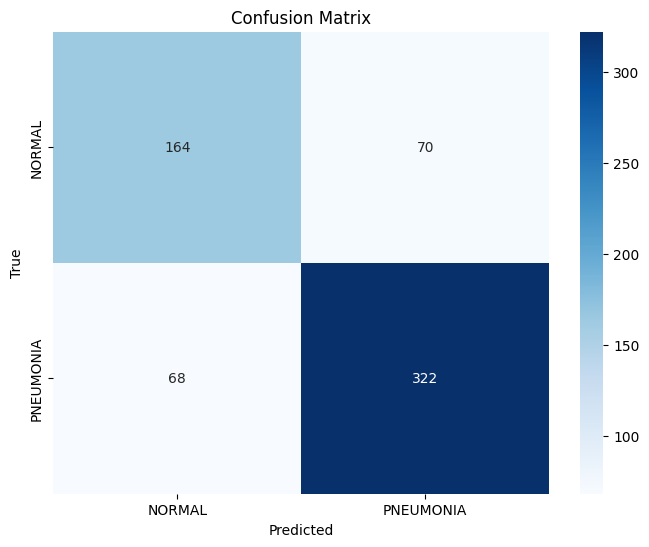

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the entire model
model_path = '/content/drive/My Drive/best_model_2.pth'
model = torch.load(model_path, map_location=device)
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Test the model and get metrics
test_loss, test_accuracy, test_f1, cm = test_model(model, device, test_loader)